# 1. Deep Dreaming on Videos

In this notebook I explore the possibility of deep dreaming frame by frame on a video. This was done as part of an art project for a music video of one of my songs. [Link to deep dream video](https://youtu.be/4vzPDCuocqM)

In the notebook I follow the following pipeline
* Break the video into frames and store in a folder
* Helper functions to resize and run deep dream iteratively
* Test on a single frame image (To find parameters that give the most desirable new image)
* Run on all frames to generate a folder of dream images
* Combine the frames to create a deep dream video

Thanks to Hvass Laboratories and his Tensorflow tutorials which I followed to understand and use this code.
(Check his amazing tutorial videos and [ipyhton notebooks](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/14_DeepDream.ipynb) ]

#### Converting video into frames Stored in a folder

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import math
from imageManipulation import *

# Image manipulation.
import PIL.Image
from scipy.ndimage.filters import gaussian_filter

In [105]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Enter the name of your video file present in ./videos/filename.mp4
videoFileName = 'filename.mp4'

# Paths to new folders for storing 1) Individual frames and 2) Video path 3) Output frames
FrameFolder = os.path.join('./frames',videoFileName[:-4])
videoPath = os.path.join('./videos',videoFileName)

# The layer to deep dream on. (Inception5h model has 12 layers) so layer can be 0-11
layer = 7

outputPath = os.path.join('./frames',f"{videoFileName[:-4]}_dream_{layer}")

# Create the frame and ourput folders if they dont exist already
if not os.path.exists(FrameFolder):
    try:
        os.makedirs(FrameFolder)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
            
if not os.path.exists(outputPath):
    try:
        os.makedirs(outputPath)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [106]:
import inception5h
from imageManipulation import *

In [107]:
# Break video up into frames and save each frame

vidcap = cv2.VideoCapture(videoPath)
success,image = vidcap.read()
count = 0
while success:
    filename = f"frame{count}.jpg"
    image_resized = resize_image(image=image, factor=0.50)
    cv2.imwrite(os.path.join(FrameFolder, filename), image_resized)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [110]:
# Download the inception5h pre trained model if not already downloaded
inception5h.maybe_download()

Data has apparently already been downloaded and unpacked.


In [111]:
# Load the model
model = inception5h.Inception5h()

#### Helper functions for resizing and iterative deep dreaming

In [8]:
def get_tile_size(num_pixels, tile_size=400):
    """
    num_pixels is the number of pixels in a dimension of the image.
    tile_size is the desired tile-size.
    """

    # How many times can we repeat a tile of the desired size.
    num_tiles = int(round(num_pixels / tile_size))
    
    # Ensure that there is at least 1 tile.
    num_tiles = max(1, num_tiles)
    
    # The actual tile-size.
    actual_tile_size = math.ceil(num_pixels / num_tiles)
    
    return actual_tile_size

In [9]:
def tiled_gradient(gradient, image, tile_size=400):
    # Allocate an array for the gradient of the entire image.
    grad = np.zeros_like(image)

    # Number of pixels for the x- and y-axes.
    x_max, y_max, _ = image.shape

    # Tile-size for the x-axis.
    x_tile_size = get_tile_size(num_pixels=x_max, tile_size=tile_size)
    # 1/4 of the tile-size.
    x_tile_size4 = x_tile_size // 4

    # Tile-size for the y-axis.
    y_tile_size = get_tile_size(num_pixels=y_max, tile_size=tile_size)
    # 1/4 of the tile-size
    y_tile_size4 = y_tile_size // 4

    # Random start-position for the tiles on the x-axis.
    # The random value is between -3/4 and -1/4 of the tile-size.
    # This is so the border-tiles are at least 1/4 of the tile-size,
    # otherwise the tiles may be too small which creates noisy gradients.
    x_start = random.randint(-3*x_tile_size4, -x_tile_size4)

    while x_start < x_max:
        # End-position for the current tile.
        x_end = x_start + x_tile_size
        
        # Ensure the tile's start- and end-positions are valid.
        x_start_lim = max(x_start, 0)
        x_end_lim = min(x_end, x_max)

        # Random start-position for the tiles on the y-axis.
        # The random value is between -3/4 and -1/4 of the tile-size.
        y_start = random.randint(-3*y_tile_size4, -y_tile_size4)

        while y_start < y_max:
            # End-position for the current tile.
            y_end = y_start + y_tile_size

            # Ensure the tile's start- and end-positions are valid.
            y_start_lim = max(y_start, 0)
            y_end_lim = min(y_end, y_max)

            # Get the image-tile.
            img_tile = image[x_start_lim:x_end_lim,
                             y_start_lim:y_end_lim, :]

            # Create a feed-dict with the image-tile.
            feed_dict = model.create_feed_dict(image=img_tile)

            # Use TensorFlow to calculate the gradient-value.
            g = session.run(gradient, feed_dict=feed_dict)

            # Normalize the gradient for the tile. This is
            # necessary because the tiles may have very different
            # values. Normalizing gives a more coherent gradient.
            g /= (np.std(g) + 1e-8)

            # Store the tile's gradient at the appropriate location.
            grad[x_start_lim:x_end_lim,
                 y_start_lim:y_end_lim, :] = g
            
            # Advance the start-position for the y-axis.
            y_start = y_end

        # Advance the start-position for the x-axis.
        x_start = x_end

    return grad

In [10]:
def optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=3.0, tile_size=400,
                   show_gradient=False):
    """
    Use gradient ascent to optimize an image so it maximizes the
    mean value of the given layer_tensor.
    
    Parameters:
    layer_tensor: Reference to a tensor that will be maximized.
    image: Input image used as the starting point.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    show_gradient: Plot the gradient in each iteration.
    """

    # True if you want to display the images it generates (Useful for parameter testing). 
    # Should be false when running on all frames.
    PRINT_FLAG = False
    
    # Copy the image so we don't overwrite the original image.
    img = image.copy()
    
    if PRINT_FLAG:
        print("Image before:")
        plot_image(img)

        print("Processing image: ", end="")

    # Use TensorFlow to get the mathematical function for the
    # gradient of the given layer-tensor with regard to the
    # input image. This may cause TensorFlow to add the same
    # math-expressions to the graph each time this function is called.
    # It may use a lot of RAM and could be moved outside the function.
    gradient = model.get_gradient(layer_tensor)
    
    for i in range(num_iterations):
        # Calculate the value of the gradient.
        # This tells us how to change the image so as to
        # maximize the mean of the given layer-tensor.
        grad = tiled_gradient(gradient=gradient, image=img)
        
        # Blur the gradient with different amounts and add
        # them together. The blur amount is also increased
        # during the optimization. This was found to give
        # nice, smooth images. You can try and change the formulas.
        # The blur-amount is called sigma (0=no blur, 1=low blur, etc.)
        # We could call gaussian_filter(grad, sigma=(sigma, sigma, 0.0))
        # which would not blur the colour-channel. This tends to
        # give psychadelic / pastel colours in the resulting images.
        # When the colour-channel is also blurred the colours of the
        # input image are mostly retained in the output image.
        sigma = (i * 4.0) / num_iterations + 0.5
        grad_smooth1 = gaussian_filter(grad, sigma=sigma)
        grad_smooth2 = gaussian_filter(grad, sigma=sigma*2)
        grad_smooth3 = gaussian_filter(grad, sigma=sigma*0.5)
        grad = (grad_smooth1 + grad_smooth2 + grad_smooth3)

        # Scale the step-size according to the gradient-values.
        # This may not be necessary because the tiled-gradient
        # is already normalized.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        img += grad * step_size_scaled

        if show_gradient:
            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            #print(msg.format(grad.min(), grad.max(), step_size_scaled))

            # Plot the gradient.
            #plot_gradient(grad)
        else:
            # Otherwise show a little progress-indicator.
            print(". ", end="")

    if PRINT_FLAG:
        print()
        print("Image after:")
        plot_image(img)
    
    return img

In [11]:
def recursive_optimize(layer_tensor, image,
                       num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=3.0,
                       tile_size=400):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.

    Parameters:
    image: Input image used as the starting point.
    rescale_factor: Downscaling factor for the image.
    num_repeats: Number of times to downscale the image.
    blend: Factor for blending the original and processed images.

    Parameters passed to optimize_image():
    layer_tensor: Reference to a tensor that will be maximized.
    num_iterations: Number of optimization iterations to perform.
    step_size: Scale for each step of the gradient ascent.
    tile_size: Size of the tiles when calculating the gradient.
    """
    
    # True if you want to display the images it generates (Useful for parameter testing). 
    # Should be false when running on all frames.
    PRINT_FLAG = False

    # Do a recursive step?
    if num_repeats>0:
        # Blur the input image to prevent artifacts when downscaling.
        # The blur amount is controlled by sigma. Note that the
        # colour-channel is not blurred as it would make the image gray.
        sigma = 0.5
        img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))

        # Downscale the image.
        img_downscaled = resize_image(image=img_blur,
                                      factor=rescale_factor)
            
        # Recursive call to this function.
        # Subtract one from num_repeats and use the downscaled image.
        img_result = recursive_optimize(layer_tensor=layer_tensor,
                                        image=img_downscaled,
                                        num_repeats=num_repeats-1,
                                        rescale_factor=rescale_factor,
                                        blend=blend,
                                        num_iterations=num_iterations,
                                        step_size=step_size,
                                        tile_size=tile_size)
        
        # Upscale the resulting image back to its original size.
        img_upscaled = resize_image(image=img_result, size=image.shape)

        # Blend the original and processed images.
        image = blend * image + (1.0 - blend) * img_upscaled

    if PRINT_FLAG:
        print("Recursive level:", num_repeats)

    # Process the image using the DeepDream algorithm.
    img_result = optimize_image(layer_tensor=layer_tensor,
                                image=image,
                                num_iterations=num_iterations,
                                step_size=step_size,
                                tile_size=tile_size)
    
    return img_result

## Test Deep dreaming on single Frame

In [116]:
model = inception5h.Inception5h()
session = tf.InteractiveSession(graph=model.graph)

C:\Users\Manaswi\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\client\session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


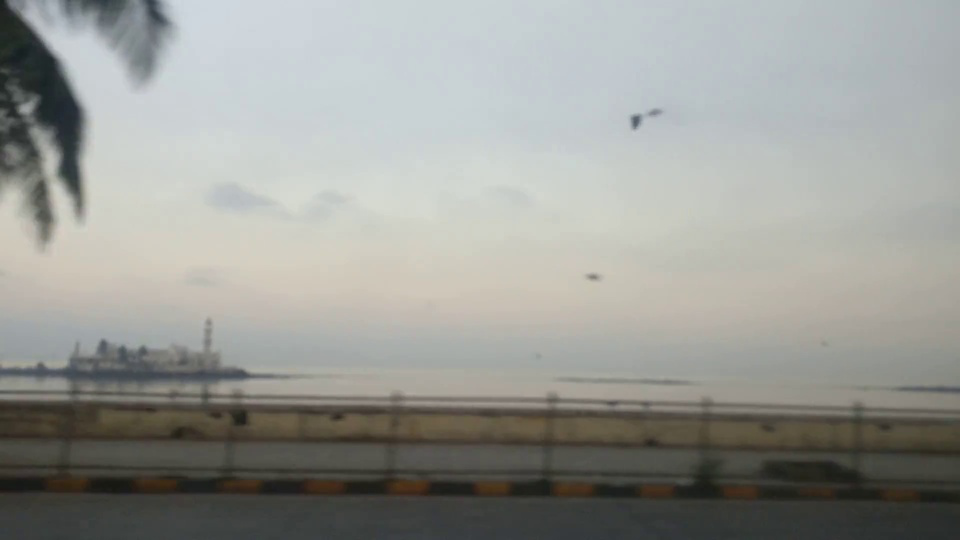

In [117]:
#image = load_image('D:/Home/Projects/ImageManipulations/ImageDreaming/checkerPattern.jpg')

image = load_image(filename=os.path.join(FrameFolder,'frame50.jpg' ))
plot_image(image)

In [119]:
layer_tensor = model.layer_tensors[7]
layer_tensor

<tf.Tensor 'mixed4c:0' shape=(?, ?, ?, 512) dtype=float32>

### A) Test deep dreaming at a single pass

Image before:


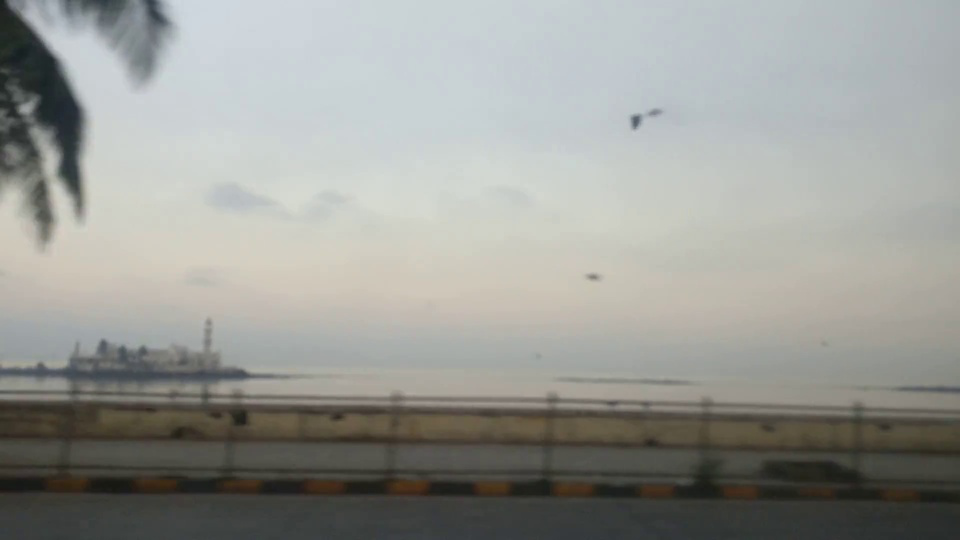

Processing image: . . . . . . . . . . 
Image after:


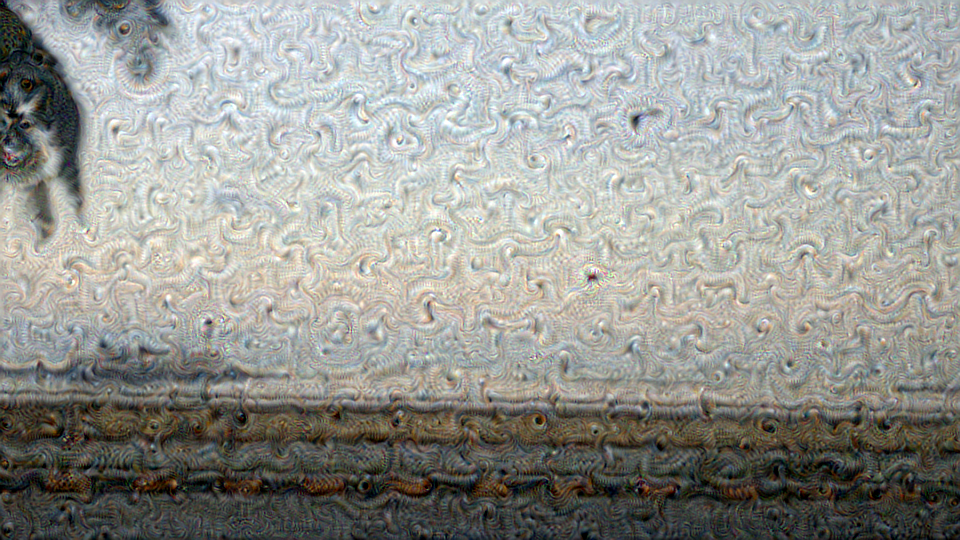

In [120]:
img_result = optimize_image(layer_tensor, image,
                   num_iterations=10, step_size=6.0, tile_size=400,
                   show_gradient=False)

### B) Test deep dreaming with recursive passes
This was done to better scale the modifications that deep dream does to larger images by performing single pass deep dream on a scaled down image ( scale at which the inception model has been trained on) 
and then blending in the original image iteratively to scale up the image to perform another pass of deep dreaming

Recursive level: 0
Image before:


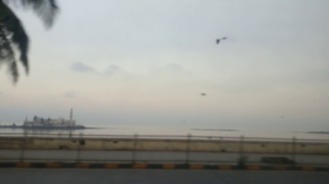

Processing image: . . . . . . . . . . 
Image after:


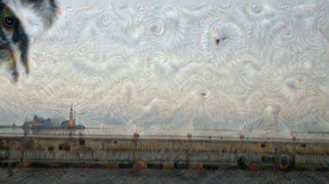

Recursive level: 1
Image before:


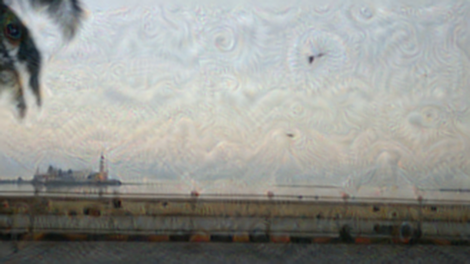

Processing image: . . . . . . . . . . 
Image after:


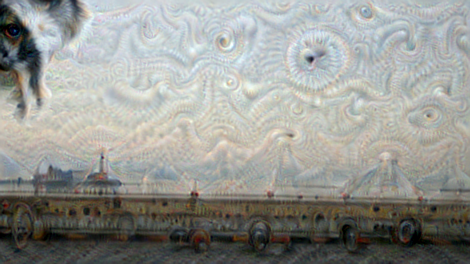

Recursive level: 2
Image before:


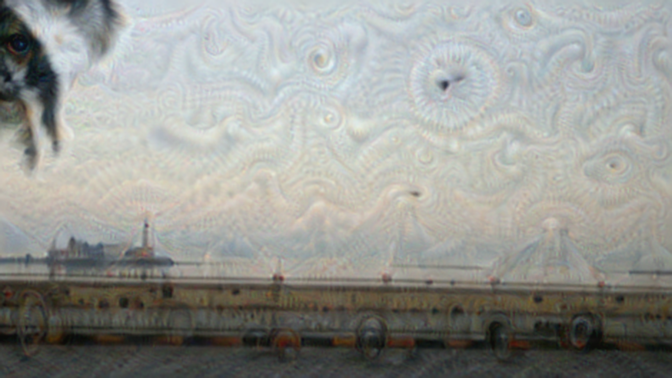

Processing image: . . . . . . . . . . 
Image after:


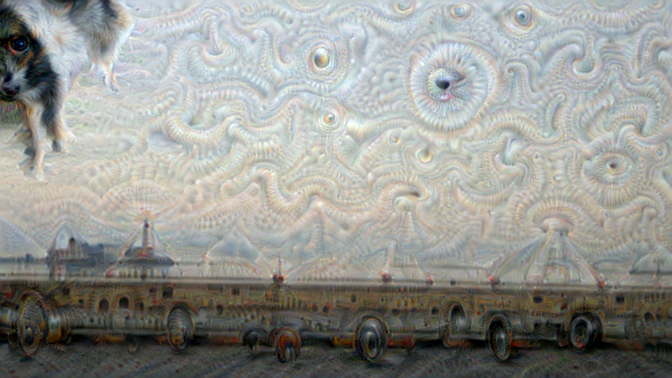

Recursive level: 3
Image before:


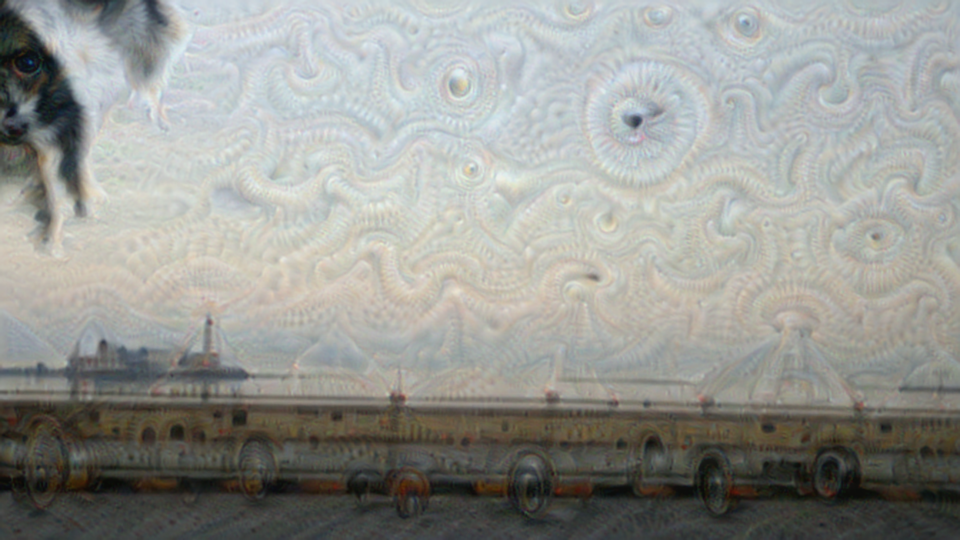

Processing image: . . . . . . . . . . 
Image after:


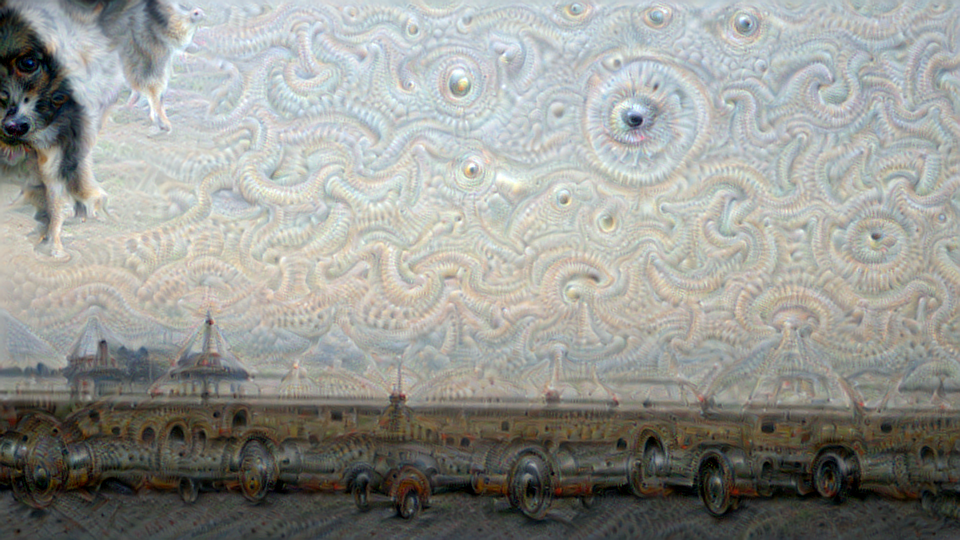

In [121]:
img_result = recursive_optimize(layer_tensor=layer_tensor, image=image,
                 num_iterations=10, step_size=3.0, rescale_factor=0.7,
                 num_repeats=3, blend=0.4)

In [122]:
#save_image(img_result, filename='checkerPattern_7.jpg')
session.close()

# Start Deep Dreaming on all the frames in a video

In [110]:
import time
framePath = FrameFolder

# Choice of layer to deep dream on
layer = 8

# Control over batches to process (Depends on your device computation capabilities. I ran ~100 frames at a time)
batch = 1

model = inception5h.Inception5h()

for frameNumber in range(10*(batch-1), 10*(batch+10)):
#for frameNumber in range(80, 1047):
    t1 = time.time()
    filename = f"frame{frameNumber}.jpg"
    print(f"Processing {filename}:")
    #session = tf.InteractiveSession(graph=model.graph)
    image = load_image(filename=os.path.join(FrameFolder,filename))

    session = tf.InteractiveSession(graph=model.graph)
    layer_tensor = model.layer_tensors[layer - 1]

    img_result = recursive_optimize(layer_tensor=layer_tensor, image=image,
         num_iterations=10, step_size=3.0, rescale_factor=0.7,
         num_repeats=3, blend=0.4)

    session.close()

    save_image(img_result, os.path.join(outputPath,filename))
    print(f"Finished dreaming on {filename}. Saved.")
    print("Processing took %.02f seconds"%((time.time()-t1)))

Processing frame220.jpg:


C:\Users\Manaswi\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\client\session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame220.jpg. Saved.
Processing took 23.50 seconds
Processing frame221.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame221.jpg. Saved.
Processing took 23.03 seconds
Processing frame222.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame222.jpg. Saved.
Processing took 23.13 seconds
Processing frame223.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame223.jpg. Saved.
Processing took 23.55 seconds
Processing frame224.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame224.jpg. Saved.
Processing took 23.86 seconds
Processing frame225.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame225.jpg. 

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame312.jpg. Saved.
Processing took 66.44 seconds
Processing frame313.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame313.jpg. Saved.
Processing took 60.24 seconds
Processing frame314.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame314.jpg. Saved.
Processing took 66.47 seconds
Processing frame315.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame315.jpg. Saved.
Processing took 62.95 seconds
Processing frame316.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame316.jpg. Saved.
Processing took 65.34 seconds
Processing frame317.jpg:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Finished dreaming on frame317.jpg. 

In [111]:
session.close()

### Save the frames into a single deep dream video

In [112]:
newVideoFileName = f"{videoFileName[:-4]}_dd_{layer}.mp4"
newVideoPath = os.path.join('./videos',newVideoFileName)

startFrame = 0
endFrame = 329

# Obtaining the shape of the image from a single image
image_path = os.path.join(outputPath, f"frame{startFrame}.jpg")
frame = cv2.imread(image_path)
height, width, channels = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter(newVideoPath, fourcc, 20.0, (width, height))

for frameNumber in range(startFrame, endFrame+1):
    filename = f"frame{frameNumber}.jpg"
    imageName = os.path.join(outputPath, filename)
    
    frame = cv2.imread(imageName)
    
    out.write(frame)
    
out.release()
cv2.destroyAllWindows()